本教程来自[kaggle教程](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook)
# 介绍

该notebook是基础学习模型的集成（组合）方法（特别是称为Stacking的集成变体）的非常基本且简单的入门基础。 简而言之，将一些基本分类器的预测用作第一级（基础），然后在第二级使用另一个模型来预测较早的第一级预测的输出。

泰坦尼克号数据集是引入这个概念的首选，因为许多Kaggle的新手都从这里开始。此外，尽管堆叠已经为许多赢得Kaggle比赛的团队负责，但在这个主题上似乎缺乏内核，所以我希望这个notebook可以填补这一空白。

我本人还是Kaggle场景的一个新手，我设法碰巧学习的第一个适当的集合/堆叠脚本是伟大的Faron在AllState Severity Claims竞赛中编写的。 该notebook中的材料大量借鉴了Faron的脚本，尽管移植时考虑了分类器的组合，而他是回归器的组合。 无论如何，请在这里查看他的脚本：

[Stacking Starter](https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867) : by Faron
03-stacking-from-faron.ipynb

我希望它能够做到公正合理，并以直观，简洁的方式传达合奏的概念。 我的另一个独立的Kaggle脚本实现了下面讨论的完全相同的组装步骤（尽管具有不同的参数），其公共LB得分为0.808，足以达到前9％，并且运行时间不到4分钟。 因此，还有很多空间可以改进并添加到该脚本中。 

In [4]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleaning

现在我们将像大多数内核一般的结构一样继续，即首先探索手边的数据，识别可能的特性工程机会，并对任何分类特性进行数字编码。

In [7]:
# Load in the train and test datasets
train = pd.read_csv('./data/Taitannike-泰坦尼克/train.csv')
test = pd.read_csv('./data/Taitannike-泰坦尼克/test.csv')

# Store our passenger ID for easy access 把我们的乘客身份证存起来，方便通行
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


我们的任务就是从分类变量中提取信息，这并不奇怪
**Feature Engineering**

在这里，必须称赞Sina非常全面和深思熟虑的[notebook工程](https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier)的想法，所以请检查他的工作

## 构建特征工程

In [8]:
full_data = [train, test]

# 我自己添加的一些特征，构建特征工程
# 给出名称的长度

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

## 显示乘客是否在泰坦尼克号上有船舱的特征
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#从Sina采取的功能工程步骤
#创建新特征FamilySize作为SibSp和Parch的组合
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# 从FamilySize创建新功能IsAlone
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# 删除“Embarked ”列中的所有NULL
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# 删除票价列中的所有null，并创建一个新特征CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

## 创建一个新特征CategoricalAge
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
## 创建一个新特征CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
## 定义特征以从乘客姓名中提取标题
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # 如果标题存在，请提取并返回。
    if title_search:
        return title_search.group(1)
    return ""

# 创建一个新特征标题，其中包含乘客姓名的标题
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
## 将所有非常见标题归为一个单独的组“稀有”
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
for dataset in full_data:
    # 映射性别
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # 映射标题
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # 映射 Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # 映射 Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # 映射 Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;    

## 特征选择

In [9]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

好了，现在已经清理了特征并提取了相关信息并删除了类别列，我们的特征现在应该全部是数字的，这种格式适合于输入到我们的机器学习模型中。 但是，在继续之前，让我们生成转换后的数据集的一些简单相关和分布图，以观察

#### Visualisations

In [10]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


#### 皮尔森相关的热图
让我们生成一些特征的相关图来看看一个特征与下一个特征的相关程度。为此，我们将使用Seaborn绘图包，它允许我们非常方便地绘制热图，如下所示

皮尔逊相关系数越高，变量之间的联系更紧密。得出哪几个特征的影响比较大。
然后，为了避免共线性的问题，也需要分析两两特征之间的关系。

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

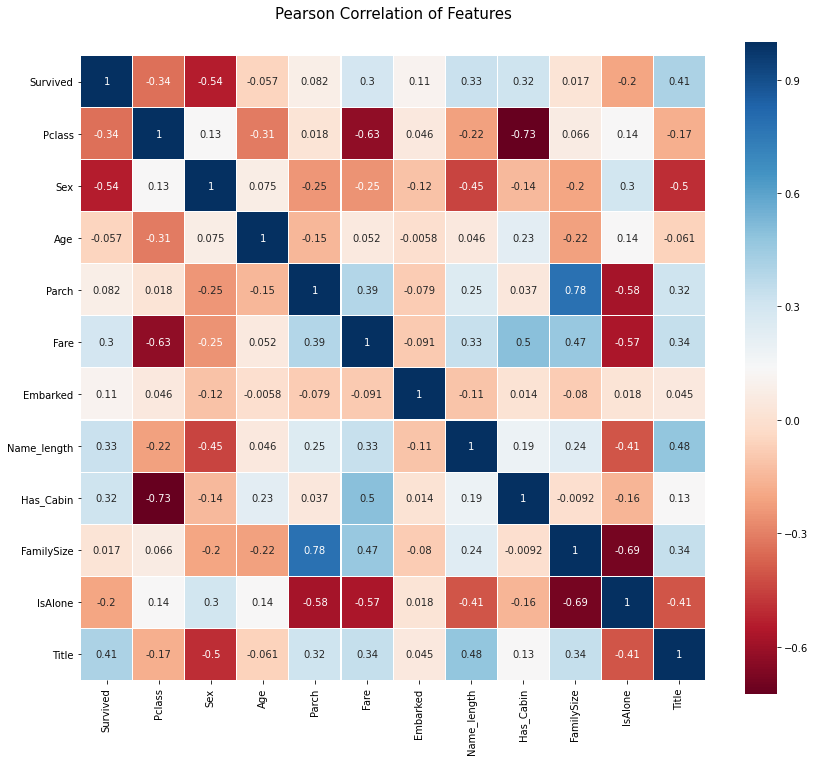

In [11]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

#### Takeaway from the Plots
皮尔逊相关图可以告诉我们的一件事是，没有太多的特征彼此之间具有很强的相关性。 从将这些功能输入到您的学习模型的角度来看，这是很好的，因为这意味着我们的训练集中没有太多冗余或多余的数据，并且我们很高兴每个特征都带有一些独特的信息。 以下是两个最相关的功能：家庭人数和家长（父母和子女）。 在本练习中，我仍将保留这两个特征。

In [15]:
train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']]

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,FamilySize,Title
0,0,3,1,1,0,0,0,2,1
1,1,1,0,2,0,3,1,2,3
2,1,3,0,1,0,1,0,1,2
3,1,1,0,2,0,3,0,2,3
4,0,3,1,2,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...
886,0,2,1,1,0,1,0,1,5
887,1,1,0,1,0,2,0,1,2
888,0,3,0,1,2,2,0,4,2
889,1,1,1,1,0,2,1,1,1


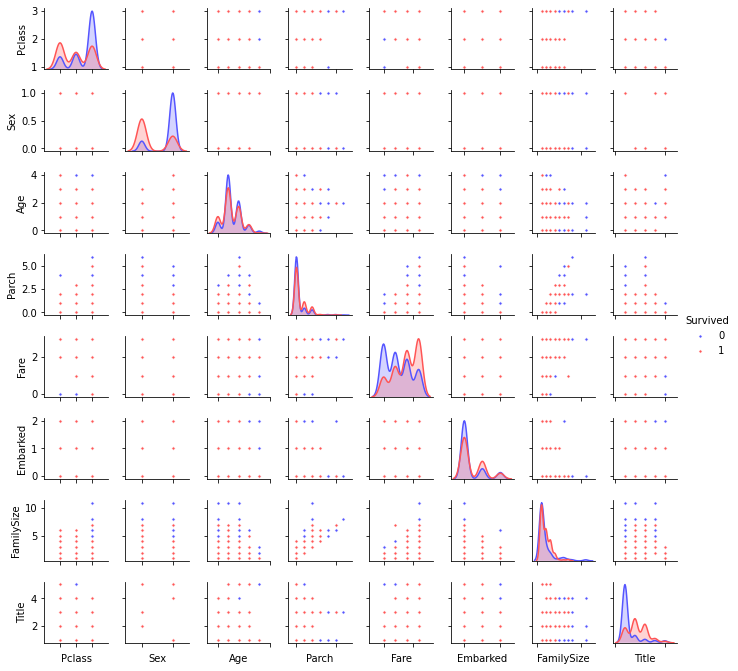

In [20]:
g = sns.pairplot(train, vars=[u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', u'FamilySize', u'Title'], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

## Ensembling & Stacking models
最后，在功能设计和格式方面短暂绕过弯路之后，我们终于了解notebook的实质和要点。

**创建堆叠集合**

通过Python类的助手
在这里，我们调用Python类的使用来帮助使其更方便。 对于任何编程新手来说，通常会听到类与面向对象编程（OOP）结合使用的情况。 简而言之，一类有助于扩展某些代码/程序来创建对象（老式偷窥者的变量），以及实现特定于该类的功能和方法。

在下面的代码部分中，我们基本上编写了一个SklearnHelper类，该类允许扩展所有Sklearn分类器通用的内置方法（例如训练，预测和拟合）。 因此，这消除了冗余，因为如果我们要调用五个不同的分类器，则不需要编写五次相同的方法。

In [23]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED, shuffle=True)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

对于那些已经知道这一点但对于以前从未在Python中创建过类或对象的人来说，请允许我，让我解释一下上面给出的代码的作用。 在创建基本分类器时，我将仅使用Sklearn库中已经存在的模型，因此仅为此扩展类。

def init：Python标准，用于调用该类的默认构造函数。 这意味着，当您要创建对象（分类器）时，必须为它指定clf（所需的sklearn分类器），种子（随机种子）和参数（分类器的参数）的参数。

其余代码只是该类的方法，它们仅调用sklearn分类器中已经存在的相应方法。 本质上，我们创建了一个包装器类来扩展各种Sklearn分类器，这样可以帮助我们减少在向堆栈器实现多个学习器时一遍又一遍地编写相同代码的麻烦。

**Out-of-Fold Predictions**
现在，如在引言部分中上文所提到的，堆叠使用基本分类器的预测作为训练第二级模型的输入。 但是，不能简单地在完整的训练数据上训练基本模型，在完整的测试集上生成预测，然后将其输出以进行第二级训练。 这冒着您的基本模型预测已经“看到”测试集并因此在提供这些预测时过度拟合的风险。

In [30]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

#### Generating our Base First-Level Models

因此，现在让我们准备五个学习模型作为我们的第一级分类。 这些模型都可以通过Sklearn库方便地调用，并列出如下：
- 1. Random Forest classifier
- 2. Extra Trees classifier
- 3. AdaBoost classifer
- 4. Gradient Boosting classifer
- 5. Support Vector Machine

**参数**

只是为了完整起见，我们将在此处列出的参数的简短摘要，                                          
**n_jobs**：用于培训过程的核心数。 如果设置为-1，则使用所有内核。                          
**n_estimators** : Number of classification trees in your learning model ( set to 10 per default)
**max_depth**：树的最大深度，或者应该扩展一个节点的数量。 提防如果设置的数字太大，则可能会导致过度拟合的风险，因为这样会使树长得太深                                                               
**verbose**: 控制在学习过程中是否要输出任何文本。 值为0会抑制所有文本，而值为3会在每次迭代时输出树学习过程。


请通过Sklearn官方网站查看完整说明。 在那里，您会发现还有很多其他有用的参数可以使用。

In [26]:
# 输入上述分类器的参数
# 随机森林参数
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

## 额外的树参数
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

## AdaBoost参数
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

## 梯度提升参数
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}


## 支持向量分类器参数
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

此外，由于已经提到了OOP框架中的对象和类，因此让我们现在通过前面定义的Helper Sklearn类创建代表5个学习模型的5个对象。

In [27]:
# Create 5 objects that represent our 4 models 创建代表我们的4个模型的5个对象
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

**从我们的训练和测试集中创建NumPy数组**                                                   
太好了。准备好我们的第一层基本模型之后，我们现在可以准备好训练和测试输入到我们的分类器的测试数据，方法是从它们的原始数据帧中生成NumPy数组，如下所示

In [28]:
## 创建训练，测试和目标（幸存）数据框的Numpy数组，以馈入我们的模型
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

**一级预测的输出**                                                                           
现在，我们将训练和测试数据输入到我们的5个基本分类器中，并使用我们之前定义的“不合群”预测函数来生成我们的一级预测。 等待几分钟，以使下面的代码块可以运行。

In [31]:
## 创建我们的OOF训练和测试预测。 这些基本结果将用作新特征
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


**不同分类器产生的特征重要性**                                                      
现在，我们已经学习了第一级分类器，我们可以利用Sklearn模型的一个非常漂亮的特征，那就是用一条非常简单的代码行输出训练和测试集中各种特征的重要性。                                                       

根据Sklearn文档，大多数分类器都内置了一个属性，该属性只需输入.featureimportances即可返回功能重要性。 因此，我们将通过我们的函数earliand plot调用此非常有用的属性，将特征重要性如此

In [33]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)


[0.10602692 0.20906654 0.03355888 0.01956476 0.04774953 0.0286178
 0.12948336 0.04770899 0.07290386 0.01195492 0.29336445]
[0.12075681 0.3784685  0.02847934 0.01727085 0.05595242 0.02773399
 0.04642933 0.08354357 0.04528245 0.0216143  0.17446843]
[0.028 0.012 0.018 0.06  0.04  0.01  0.706 0.012 0.046 0.004 0.064]
[0.08871435 0.01066524 0.05203175 0.01155154 0.05052902 0.02824642
 0.17439918 0.03665226 0.11313044 0.00617411 0.42790569]


所以我还没有弄清楚如何分配和存储特性的重要性。因此，我将从上面的代码中打印出值，然后简单地复制并粘贴到下面的Python列表中(抱歉，这是糟糕的hack)

In [34]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

从包含特性重要数据的列表中创建一个数据帧，以便通过Plotly包进行绘图。

In [36]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [37]:
cols

array(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Name_length',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'], dtype=object)

#### 通过Plotly散点图的互动特征重要性

在这一点上，我将使用交互式Plotly包，通过按如下所示调用“散点图”，通过散点图来可视化不同分类器的特征重要性值：

In [39]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

AttributeError: module 'plotly.offline' has no attribute 'showscale'

现在让我们计算所有特征重要性的平均值，并将其存储为特征重要性数据框中的新列。

In [40]:
# Create the new column containing the average of values
print(feature_dataframe.head())
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

  features  Random Forest feature importances  \
0   Pclass                           0.104741   
1      Sex                           0.218370   
2      Age                           0.044327   
3    Parch                           0.022492   
4     Fare                           0.054326   

   Extra Trees  feature importances  AdaBoost feature importances  \
0                          0.121657                      0.028000   
1                          0.370983                      0.008000   
2                          0.031296                      0.012000   
3                          0.015916                      0.058667   
4                          0.055258                      0.032000   

   Gradient Boost feature importances  
0                            0.067961  
1                            0.038893  
2                            0.072378  
3                            0.026286  
4                            0.111944  


,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


#### 平均特征重要性的绘图条形图                                                          
在获得所有分类器的平均特征重要性后，我们可以将它们绘制成Plotly条形图，如下所示：

In [41]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

#### 来自第一级输出的第二级预测
**一级输出作为新特征**      

现在，我们已经获得了一级预测，就可以认为它实际上是在构建一组新特征，以用作下一个分类器的训练数据。 因此，按照下面的代码，我们将来自较早分类器的第一级预测作为新的列，并在此基础上训练下一个分类器。


In [42]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


二级训练集的相关热图

In [43]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

关于Kaggle竞赛优胜者的文章，已经有很多篇文章讲述了训练有素的模型彼此之间的不相关性以及产生更好分数的优点。

In [44]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

现在已经将第一级训练和测试预测作为x_train和x_test串联并加入，我们现在可以拟合第二级学习模型。

**通过XGBoost进行二级学习的模型**

在这里，我们选择非常著名的用于增强树学习模型的库XGBoost。 它是为优化大规模增强树算法而构建的。 有关该算法的更多信息，[请查阅官方文档](https://xgboost.readthedocs.io/en/latest/)。

无论如何，我们调用XGBClassifier并将其拟合到第一级训练和目标数据，并使用学习的模型来预测测试数据，如下所示：

In [45]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

[13:46:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


只需快速运行一下模型中使用的XGBoost参数即可：

**max_depth**：您想种多深的树。 当心，如果设置的数字太大，可能会导致过度拟合的风险。

**gamma**：在树的叶节点上进行进一步分区所需的最小损失减少。 越大，算法将越保守。

**eta**：在每个增强步骤中使用的步长收缩，以防止过度拟合

##### 生成提交文件
最终，我们对所有一级和二级模型进行了训练和拟合后，现在可以将预测结果输出为正确的格式，以提交给《泰坦尼克号》竞赛，如下所示：

In [47]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("./data/Taitannike-泰坦尼克/StackingSubmission.csv", index=False)

#### 进一步改善的步骤

作为结束语，必须注意，上述步骤仅显示了一种非常简单的生产整体堆垛机的方法。 您会听到在Kaggle最高级别比赛中创建的合奏，其中涉及堆叠分类器的怪异组合以及堆叠的级别（超过2个级别）。

可以采取一些其他措施来提高自己的分数：
- 1. 在训练模型以找到最佳参数值时实施良好的交叉验证策略
- 2. 介绍更多用于学习的基本模型。 结果越不相关，最终得分就越好。

#### 结论

我认为这个notebook在介绍用于stacking学习模型的工作脚本方面有所帮助。 同样，信用必须扩展到Faron和Sina。

有关一般而言其他有关堆叠或组装的出色材料，请参阅MLWave网站上的事实上的必读文章：[Kaggle组装指南](http://mlwave.com/kaggle-ensembling-guide/)。

下次再见，再见

